In [1]:
import json
from tqdm import tqdm
import torch
import time
with open('w2id++.json', 'r') as f:
    w2id = json.load(f)
with open('id2w++.json', 'r') as f:
    id2w = json.load(f)
    
data_list = []
with open('data_splited++.jl', 'r') as f:
    for l in f:
        data_list.append(json.loads(l))
embedding = []
with open('embedding++.jl', 'r') as f:
    for l in f:
        embedding.append(json.loads(l))
        
batch_size = 128
data_workers = 4
learning_rate = 0.0001
gradient_accumulation_steps = 1
max_train_epochs = 30
warmup_proportion = 0.05
weight_decay=0.01
max_grad_norm=1.0
cur_time = time.strftime("%Y-%m-%d_%H:%M:%S")
device = torch.device('cuda')

In [2]:
dlx = [[] for _ in range(5)]
for d in data_list:
    dlx[len(d[0]) - 5].append(d)

In [3]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, examples):
        self.examples = examples
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, index):
        example = self.examples[index]
        s1 = example[0]
        s2 = example[1]
        return s1, s2, index
def str2id(s):
    ids = []
    for ch in s:
        if ch in w2id:
            ids.append(w2id[ch])
        else:
            ids.append(0)
    return ids
def the_collate_fn(batch):
    s1x = []
    s2x = []
    for b in batch:
        s1 = str2id(b[0])
        s2 = str2id(b[1])
        s1x.append(s1)
        s2x.append(s2)
    indexs = [b[2] for b in batch]
    s1 = torch.LongTensor(s1x)
    s2 = torch.LongTensor(s2x)
    return s1, s2, indexs

dldx = []
for d in dlx:
    ds = MyDataSet(d)
    dld = torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
        shuffle = True,
        num_workers=data_workers,
        collate_fn=the_collate_fn,
    )
    dldx.append(dld)

In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, s1, s2=None):
        batch_size, length = s1.shape[:2]
        s1 = self.encoder(s1) * math.sqrt(self.ninp)
        s1 = self.pos_encoder(s1)
        output = self.transformer_encoder(s1)
        output = self.decoder(output)
        output = F.log_softmax(output, dim=2)
        if s2 is not None:
            criterion = nn.NLLLoss()
            loss = criterion(output.view(batch_size*length, -1), s2.view(batch_size*length))
            return loss
        return output

In [5]:
ntokens = len(w2id)
emsize = 300 # embedding dimension
nhid = 256 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [6]:
def t2s(t):
    l = t.cpu().tolist()
    r = [id2w[x] for x in l[0]]
    return ''.join(r)

def get_next(s):
    ids = torch.LongTensor(str2id(s))
    print(s)
    ids = ids.unsqueeze(0).to(device)
    with torch.no_grad():
        r = model(ids)
        r = r.argmax(dim=2)
        return t2s(r)
def print_cases():
    print(get_next('好好学习') + '\n')
    print(get_next('白日依山尽') + '\n')
    print(get_next('学而时习之') + '\n')
    print(get_next('人之初性本善') + '\n')

In [7]:
print_cases()

好好学习
薇亦畚呜

白日依山尽
呜缁搏鼐识

学而时习之
飓遵壕鼐摆

人之初性本善
葫俞檠杜灼蹇



In [8]:
from transformers import AdamW, get_linear_schedule_with_warmup

t_total = len(data_list) // gradient_accumulation_steps * max_train_epochs + 1
num_warmup_steps = int(warmup_proportion * t_total)

print('warmup steps : %d' % num_warmup_steps)

no_decay = ['bias', 'LayerNorm.weight'] # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [
    {'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay': weight_decay},
    {'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)

warmup steps : 1675108


In [9]:
loss_list = []
for e in range(max_train_epochs):
    print(e)
    loss_sum = 0
    c = 0
    xxx = [x.__iter__() for x in dldx]
    j = 0
    for i in tqdm(range((len(data_list)//batch_size) + 5)):
        if len(xxx) == 0:
            break
        j = j % len(xxx)
        try:
            batch = xxx[j].__next__()
        except StopIteration:
            xxx.pop(j)
            continue
        j += 1
        s1, s2, index = batch
        s1 = s1.to(device)
        s2 = s2.to(device)
        loss = model(s1, s2)
        loss_sum += loss.item()
        c += 1
        loss.backward()
        optimizer.step()
        scheduler.step() 
        optimizer.zero_grad()
    print_cases()
    print(loss_sum / c)
    loss_list.append(loss_sum / c)

0


100%|██████████| 8729/8729 [07:45<00:00, 18.75it/s]


好好学习
流摇深虬

白日依山尽
临春不不不

学而时习之
□归枵弹自

人之初性本善
不自不春一峦

8.870945400248967
1


100%|██████████| 8729/8729 [07:47<00:00, 18.68it/s]

好好学习
深一□不

白日依山尽
无不一不不

学而时习之
无不此不一

人之初性本善
不为不一一一

7.897064124711264
2



100%|██████████| 8729/8729 [07:43<00:00, 18.83it/s]

好好学习
不不不风

白日依山尽
不山不不不

学而时习之
何风不不风

人之初性本善
不不不不不山

7.370467955854356
3



100%|██████████| 8729/8729 [07:56<00:00, 18.31it/s]

好好学习
一此日自

白日依山尽
年时有无人

学而时习之
人知自风山

人之初性本善
人来人云人人

7.27033402483921
4



100%|██████████| 8729/8729 [07:26<00:00, 19.56it/s]

好好学习
人何人风

白日依山尽
人风不为生

学而时习之
人云生风人

人之初性本善
人年人风生风

7.240776638861713
5



100%|██████████| 8729/8729 [08:09<00:00, 17.84it/s]


好好学习
未无不风

白日依山尽
年生人不名

学而时习之
天有生风人

人之初性本善
人我风风人何

7.21359644739539
6


100%|██████████| 8729/8729 [07:53<00:00, 18.45it/s]

好好学习
流声日风

白日依山尽
春风不风人

学而时习之
清有我风山

人之初性本善
不游一不风风

7.182166251535061
7



100%|██████████| 8729/8729 [07:59<00:00, 18.21it/s]


好好学习
归天日风

白日依山尽
春风无为归

学而时习之
心不不风楼

人之初性本善
不回不不不事

7.145359160251125
8


100%|██████████| 8729/8729 [07:54<00:00, 18.40it/s]

好好学习
归新来风

白日依山尽
春风一水归

学而时习之
春有上风山

人之初性本善
得山一春人作

7.098595275332388
9



100%|██████████| 8729/8729 [07:53<00:00, 18.42it/s]

好好学习
春春中春

白日依山尽
秋时不水新

学而时习之
年不有风月

人之初性本善
日涯不无未山

7.050091004194025
10



100%|██████████| 8729/8729 [07:54<00:00, 18.40it/s]

好好学习
新新日千

白日依山尽
青云一水生

学而时习之
中两有何见

人之初性本善
上之不明未流

7.00925423477304
11



 70%|███████   | 6116/8729 [05:27<02:22, 18.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 8729/8729 [07:56<00:00, 18.32it/s]

好好学习
归长见风

白日依山尽
青年一上还

学而时习之
上有处不之

人之初性本善
有之不不无与

6.887981681550471
15



100%|██████████| 8729/8729 [08:01<00:00, 18.11it/s]


好好学习
何何觉长

白日依山尽
青天不水长

学而时习之
日不日不之

人之初性本善
见之不在亦与

6.845888587875147
17


  5%|▍         | 410/8729 [00:20<06:54, 20.08it/s]


KeyboardInterrupt: 

Matplotlib is building the font cache; this may take a moment.


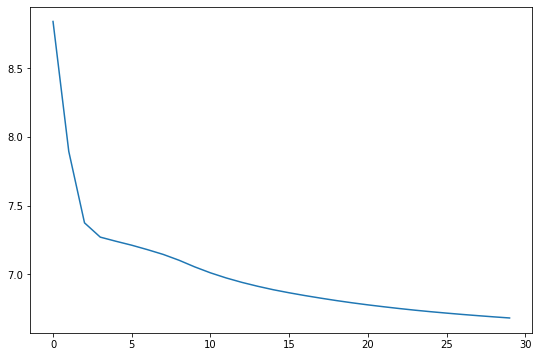

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize=(9,6))
plt.plot([i for i in range(len(loss_list))], loss_list)

In [20]:
torch.save(model.state_dict(), 'transform_model_parameter.pkl')

In [22]:
torch.save(model, 'transform_model.pkl')

/usr/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type TransformerModel. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/usr/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [ ]:
rnn = torch.load('rnn_model.pkl'))
rnn.load_state_dict(torch.load('rnn_parameter.pkl'))